# **Market Stock Prediction Using Batch Learning**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import plotly

In [3]:
data = pd.read_csv('./data/BTCUSDT.csv', index_col=0)
data.index = pd.to_datetime(data['date'])
data = data.drop(columns=['date'])
data.shape

(1000, 5)

In [4]:
data.head()

,open,high,low,close,volume
date,,,,,
2024-12-11 23:00:00,101209.74,101500.00,101068.25,101125.00,672.65371
2024-12-12 00:00:00,101125.00,101200.00,100559.71,100772.46,970.26535
2024-12-12 01:00:00,100772.47,100861.98,100331.61,100496.30,1065.71101
2024-12-12 02:00:00,100496.30,101824.77,100496.30,101824.76,1067.28192
2024-12-12 03:00:00,101824.77,101829.00,100792.00,101025.87,1481.01937


In [5]:
data.index.max(), data.index.min() 

(Timestamp('2025-01-22 14:00:00'), Timestamp('2024-12-11 23:00:00'))

What we want to predict/forcast is the close price.

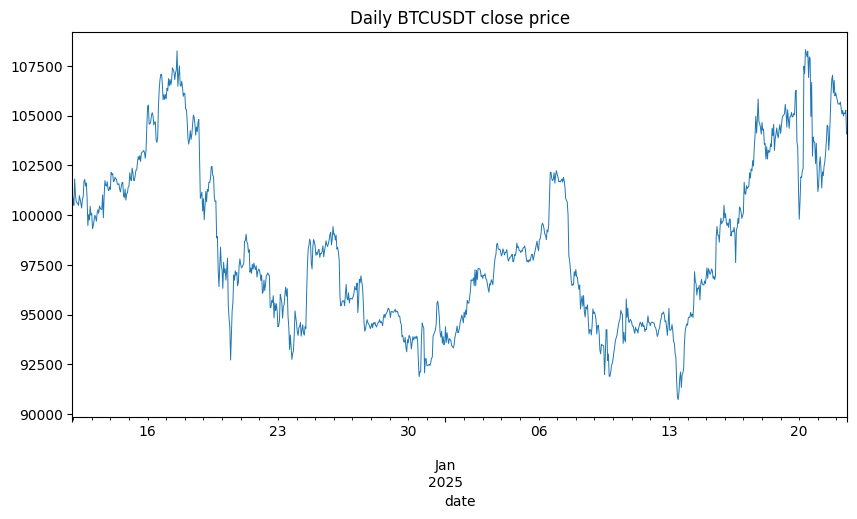

In [6]:
plt.figure(figsize=(10, 5))
data['close'].plot(linewidth=0.7)
plt.title("Daily BTCUSDT close price")
plt.show()


In [7]:
data['close'].describe()


count      1000.000000
mean      98459.655590
std        4070.815627
min       90732.000000
25%       94862.445000
50%       97673.950000
75%      101652.212500
max      108320.010000
Name: close, dtype: float64

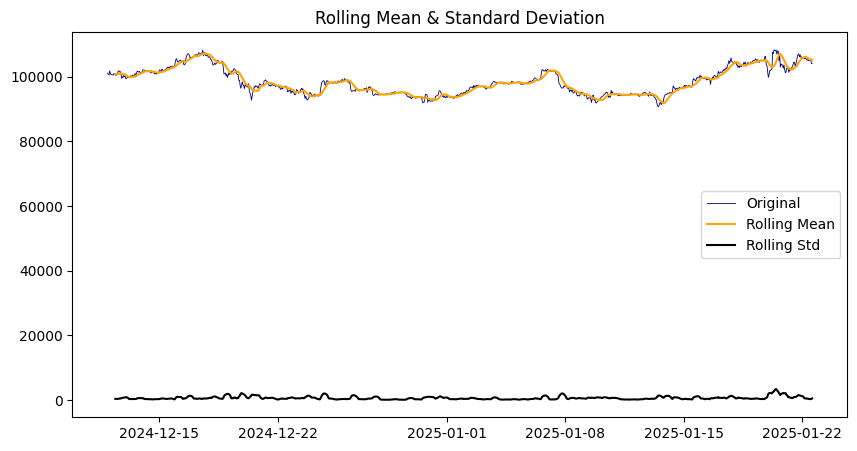

Results of Dickey-Fuller Test:
Test Statistic                  -1.396897
p-value                          0.583763
#Lags Used                      22.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    # Plot rolling statistics:
    plt.figure(figsize=(10, 5))
    orig = plt.plot(timeseries, color='navy',label='Original', linewidth=0.6)
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC') #autolag = 'AIC' is the Akaike Information Criterion
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(data['close'])


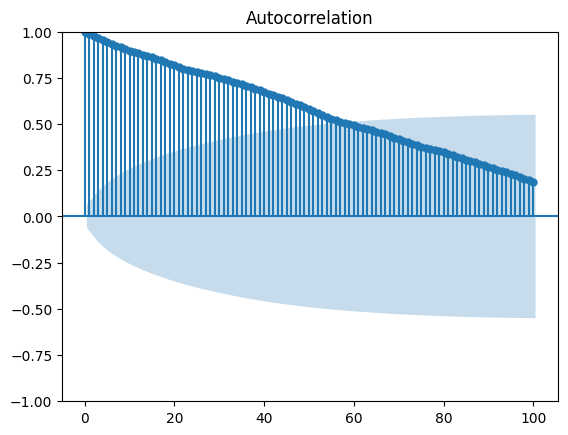

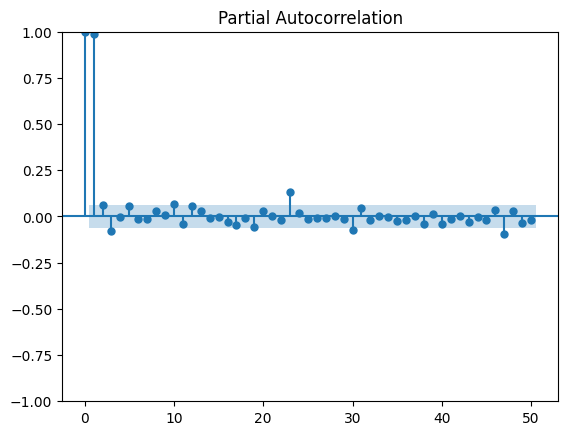

In [9]:
plot_acf(data['close'], lags=100)
plt.show()
plot_pacf(data['close'], lags=50)
plt.show()


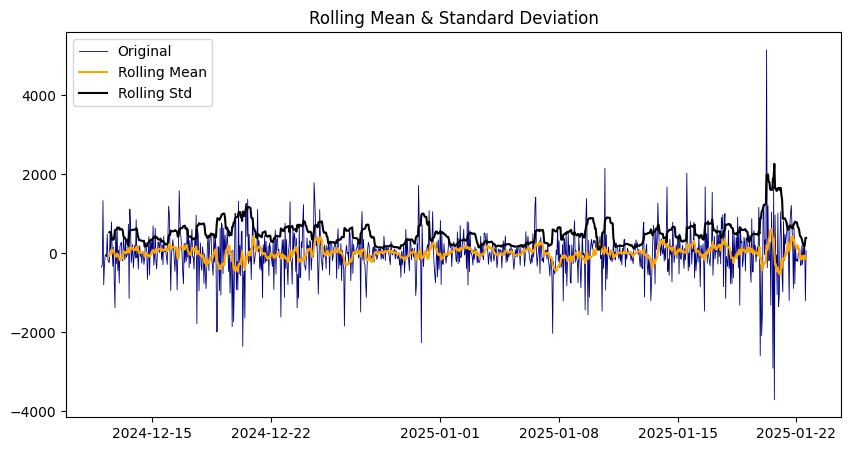

Results of Dickey-Fuller Test:
Test Statistic                -7.667135e+00
p-value                        1.629863e-11
#Lags Used                     2.100000e+01
Number of Observations Used    9.770000e+02
Critical Value (1%)           -3.437061e+00
Critical Value (5%)           -2.864503e+00
Critical Value (10%)          -2.568348e+00
dtype: float64


In [10]:
diff = data['close'].diff().dropna()
test_stationarity(diff)


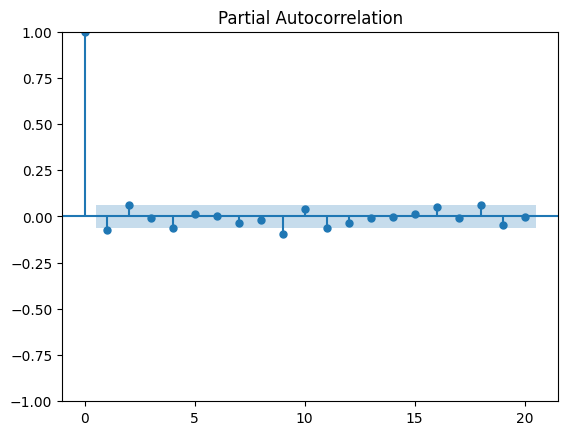

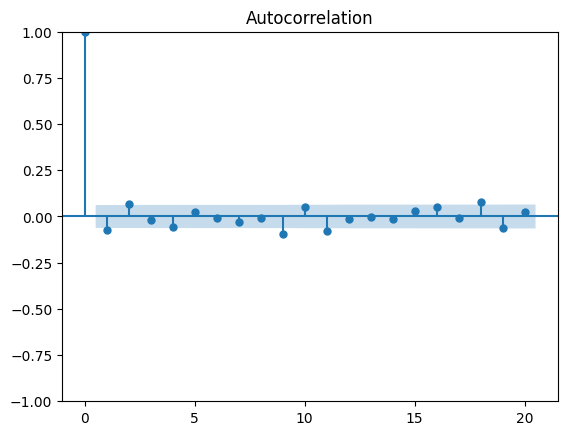

In [11]:
plot_pacf(diff, lags=20)
plt.show()
plot_acf(diff, lags=20)
plt.show()

So we will adopt a model : p = 1, d = 1, q = 1

In [12]:
y_train, y_test = data['close'][:int(len(data)*0.7)], data['close'][int(len(data)*0.7):]
x_train, x_test = data.drop('close', axis=1)[:int(len(data)*0.7)], data.drop('close', axis=1)[int(len(data)*0.7):]

In [13]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((700, 4), (300, 4), (700,), (300,))

In [14]:
y_train.head()

date
2024-12-11 23:00:00    101125.00
2024-12-12 00:00:00    100772.46
2024-12-12 01:00:00    100496.30
2024-12-12 02:00:00    101824.76
2024-12-12 03:00:00    101025.87
Name: close, dtype: float64

In [15]:
import plotly.graph_objects as go
import numpy as np
# PLOT PREDICTIONS 
def Go_plot_predictions(model_fit, data, y_train, y_test, x_test):
    fig_predictions = go.Figure()

    # Real data
    fig_predictions.add_trace(go.Scatter(
        y=data['close'], 
        mode='lines', 
        line=dict(color='black', width=1.3),
        name='Real'
    ))

    # Predicted data
    fitted_values = model_fit.fittedvalues
    forecast_values = model_fit.forecast(steps=len(y_test), exog=x_test.values)
    predicted = np.concatenate([fitted_values, forecast_values])
    fig_predictions.add_trace(go.Scatter(
        y=predicted,
        mode='lines',
        line=dict(color='orange', width=1.3),
        name='Predicted'
    ))

    # Layout settings
    fig_predictions.update_layout(
        title='ARIMAX Model Forecasting of BTCUSDT Close Price',
        xaxis_title='Time',
        yaxis_title='Value',
        template='plotly_white',
        height=600,
        width=900
    )
    # divide the graph into two parts a left part for training data and a right part for testing data, fill the part with different colors
    fig_predictions.add_shape(
        type="rect",
        x0=0,
        x1=len(y_train),
        y0=0,
        y1=data['close'].max(),
        line=dict(width=0),
        fillcolor="LightSkyBlue",
        opacity=0.1,
        layer="below", 
        name='Training phase'
    )

    fig_predictions.add_shape(
        type="rect",
        x0=len(y_train),
        x1=len(data),
        y0=0,
        y1=data['close'].max(),
        line=dict(width=0),
        fillcolor="LightCoral",
        opacity=0.1,
        layer="below", 
        name='Testing phase'
    )

    fig_predictions.show()
    # PLOT RESIDUALS
    fig_residuals = go.Figure()

    # Residuals data
    fig_residuals.add_trace(go.Scatter(
        y= np.concatenate([model_fit.resid, - forecast_values + y_test]),
        mode='lines',
        line=dict(color='purple', width=0.7),
        name='Residuals'
    ))

    # Layout settings
    fig_residuals.update_layout(
        title='ARIMA Model Residuals',
        xaxis_title='Time',
        yaxis_title='Residuals',
        template='plotly_white',
        height=600,
        width=850
    )

    fig_residuals.show()

In [16]:
# metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def metrics(y_true, y_pred):
    mse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, r2, mape

    - Seasonal ARIMA model

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(y_train.values, order=(1,1,1))#, exog= x_train.values)
model_fit = model.fit()

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5352.640
Date:                Wed, 22 Jan 2025   AIC                          10711.280
Time:                        15:54:23   BIC                          10724.929
Sample:                             0   HQIC                         10716.557
                                - 700                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9525      0.033    -28.451      0.000      -1.018      -0.887
ma.L1          0.9702      0.029     33.376      0.000       0.913       1.027
sigma2      2.624e+05   8900.340     29.483      0.000    2.45e+05     2.8e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               315.33
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:

Go_plot_predictions(model_fit, data, y_train, y_test, x_test)

In [19]:
mse, mae, r2, mape = metrics(y_test, model_fit.forecast(steps=len(y_test)))
print("Test metrics FOR SARIMA:")
print(f'RMSE: {mse}\nMAE: {mae}\nR2: {r2}\nMAPE: {mape}')


Test metrics FOR SARIMA:
RMSE: 7705.490235028812
MAE: 6251.032636327441
R2: -1.7161621806761032
MAPE: 0.06084342609144635


    - ARIMAX

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(y_train.values, order=(1,1,1), exog=x_train.values)
model_fit = model.fit()
model_fit.summary()

c:\Users\akilh\OneDrive\Bureau\TELECOM_3A\DataScience-X\DataStreamProcessing\project\StockMarketPrediction\myvenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4748.674
Date:                Wed, 22 Jan 2025   AIC                           9511.348
Time:                        15:55:31   BIC                           9543.195
Sample:                             0   HQIC                          9523.660
                                - 700                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5299      0.020    -26.626      0.000      -0.569      -0.491
x2             0.7551      0.026     28.662      0.000       0.703       0.807
x3             0.7733      0.024     31.698      0.000       0.725       0.821
x4             0.0231      0.009      2.491      0.013       0.005       0.041
ar.L1          0.0212      0.028      0.759      0.448      -0.034       0.076
ma.L1         -1.0000      0.036    -27.557      0.000      -1.071      -0.929
sigma2      4.637e+04   7.83e-07   5.93e+10      0.000    4.64e+04    4.64e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):               478.13
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.12e+26. Standard errors may be unstable.
"""

In [22]:
Go_plot_predictions(model_fit, data, y_train, y_test, x_test)

In [23]:

mse, mae, r2, mape = metrics(y_test, model_fit.forecast(steps=len(y_test), exog=x_test.values))
print("Test metrics FOR SARIMAX:")
print(f'RMSE: {mse}\nMAE: {mae}\nR2: {r2}\nMAPE: {mape}')


Test metrics FOR SARIMAX:
RMSE: 286.88660309367657
MAE: 197.38028130862332
R2: 0.9962349071949046
MAPE: 0.001964793748726302


We conclude that the multiple linear regression model is the best model for this dataset.

In [24]:
# Use prophet model to predict the future price of BTCUSDT
from prophet import Prophet

m = Prophet()

data_prophet = pd.DataFrame(y_train)
data_prophet['ds'] = data_prophet.index
data_prophet.columns = ['y', 'ds']
m.fit(data_prophet)


c:\Users\akilh\OneDrive\Bureau\TELECOM_3A\DataScience-X\DataStreamProcessing\project\StockMarketPrediction\myvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

15:56:14 - cmdstanpy - INFO - Chain [1] start processing
15:56:16 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
y_test_prophet = pd.DataFrame(y_test)
y_test_prophet['ds'] = y_test_prophet.index
y_test_prophet.columns = ['y', 'ds']

future = m.make_future_dataframe(periods=len(y_test))
future.tail()


,ds
995,2025-11-02 02:00:00
996,2025-11-03 02:00:00
997,2025-11-04 02:00:00
998,2025-11-05 02:00:00
999,2025-11-06 02:00:00


In [26]:
forcast = m.predict(future)
forcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
995,2025-11-02 02:00:00,-134382.317774,-6.816279e+06,6.601997e+06
996,2025-11-03 02:00:00,-133960.158147,-6.846985e+06,6.639759e+06
997,2025-11-04 02:00:00,-132616.724391,-6.876700e+06,6.669275e+06
998,2025-11-05 02:00:00,-135447.666065,-6.902466e+06,6.692164e+06
999,2025-11-06 02:00:00,-138623.862967,-6.925724e+06,6.714525e+06


In [27]:
from prophet.plot import plot_plotly, plot_components_plotly

fig = plot_plotly(m, forcast, xlabel='Date', ylabel='Close Price')
fig.show()


In [28]:
# plot using plotly the close price and the forecasted price
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['close'], 
    mode='lines', 
    line=dict(color='brown', width=1.3),
    name='Real'
))

fig.add_trace(go.Scatter(
    x=forcast['ds'], 
    y=forcast['yhat'], 
    mode='lines', 
    line=dict(color='orange', width=1.3),
    name='Predicted'
))

fig.update_layout(
    title='Prophet Model Forecasting of BTCUSDT Close Price',
    xaxis_title='Time',
    yaxis_title='Value',
    template='plotly_white',
    height=600,
    width=900
)

fig.show()

    - LSTM :

In [ ]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
from torch.autograd import Variable
from skorch.callbacks import EarlyStopping
import torch.optim as optim
from skorch import NeuralNetRegressor

import optuna